Calculating best minimal value for power law fit


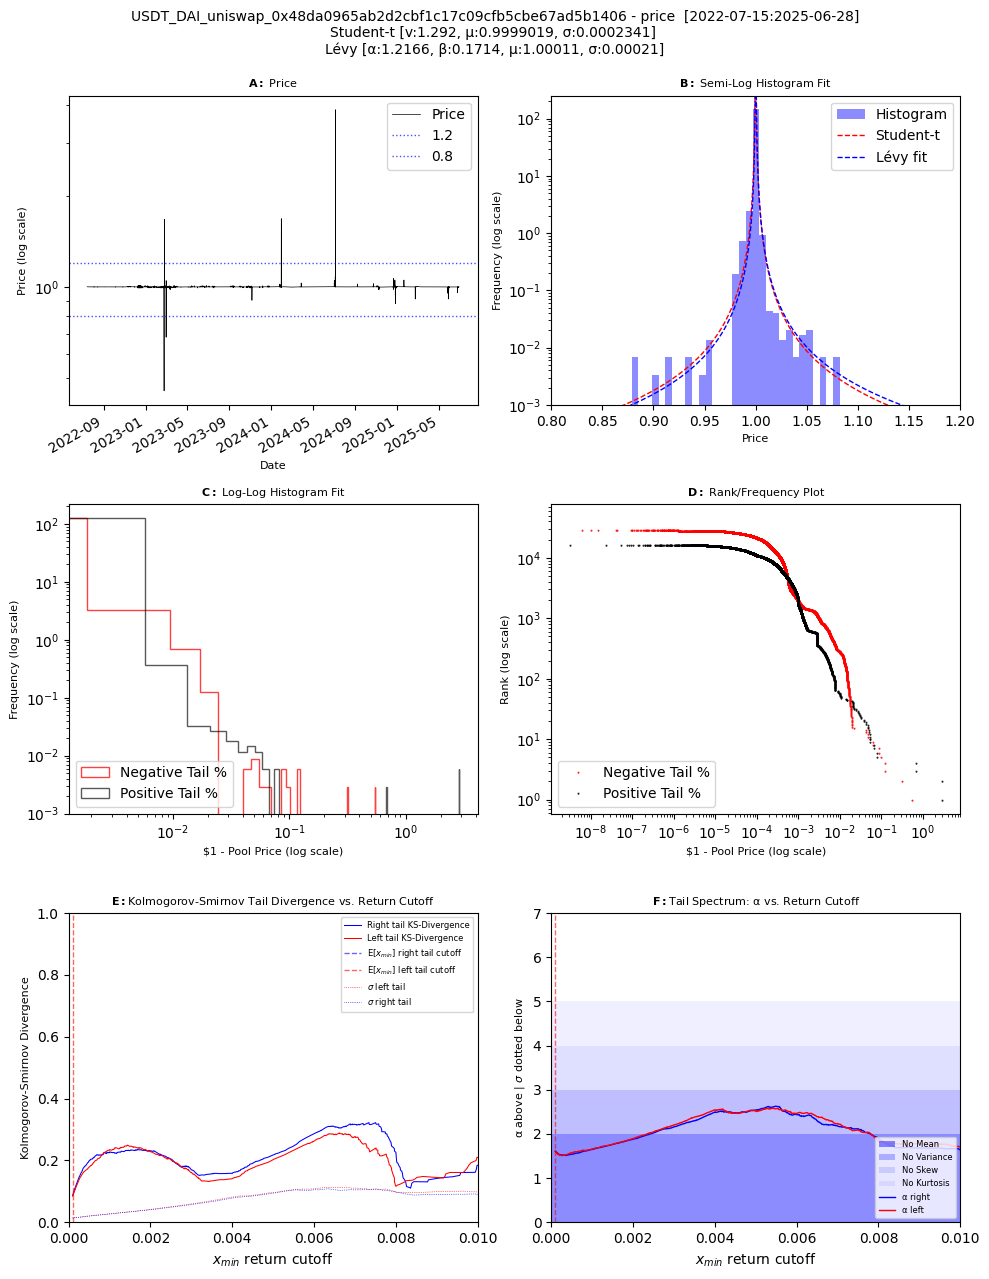

In [6]:
import math
import timeit
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as stats
from scipy.stats import levy_stable
import statsmodels.api as sm
from matplotlib.pylab import plot

"""
Examination of price dispersion of stablecoin pools

Stablecoin pools:
    USDC_DAI_uniswap_0x5777d92f208679DB4b9778590Fa3CAB3aC9e2168
    USDT_DAI_uniswap_0x48da0965ab2d2cbf1c17c09cfb5cbe67ad5b1406
    USDC_USDT_uniswap_0x3416cF6C708Da44DB2624D63ea0AAef7113527C6   
"""

title='USDC_USDT_uniswap_0x3416cF6C708Da44DB2624D63ea0AAef7113527C6'
df_pool = pd.read_csv('data_euler/'+title+'.csv') #link to the folder containing the pool data
df_pool['evt_block_time'] = pd.to_datetime(df_pool['evt_block_time'], utc=True)
df = df_pool
column_select='price'
df['Price'] = pd.to_numeric(df[column_select], errors='coerce')
df['Returns'] = df[column_select].pct_change(1)  # Daily percentage change
df['Date'] = df_pool['evt_block_time']

t_0=df['Date'].iloc[0].strftime('%Y-%m-%d')
t_f=df['Date'].iloc[-1].strftime('%Y-%m-%d')

t_0name=df['Date'].min()
t_fname=df['Date'].max()
       
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,13))
fig.suptitle(f"{title} - { column_select} Time Interval [{t_0name}:{t_fname}]", fontsize=9)
df.plot(x='Date', y='Price', ax=axes[0,0], logy=True, linewidth=0.5, color='k', label='Price')
axes[0, 0].set_title(r'$\bf{A:}$ Price', fontsize=8)
axes[0,0].set_xlabel("Date", fontsize=8)
axes[0,0].set_ylabel("Price (log scale)", fontsize=8)
axes[0,1].set_yscale('log')  # Semi-log y-axis
#axes[0,0].grid(visible=True, which='minor', axis='both', color='k', linestyle=':', alpha=0.25)
bound_upper=1.2
bound_lower=.8
#axes[0,0].axhline(1, alpha=1, label='$1',color='r', linestyle=':', linewidth=1)#linestyle=':'
axes[0,0].axhline(bound_upper, alpha=.7, label=bound_upper,color='b', linestyle=':', linewidth=1)#linestyle=':'
axes[0,0].axhline(bound_lower, alpha=.7, label=bound_lower,color='b', linestyle=':', linewidth=1)#linestyle=':'

axes[0,0].legend()
#histtype='step'
df['Price'].dropna().hist(ax=axes[0,1], bins=520, color='b', alpha=0.45, density=True, label='Histogram')
axes[0,1].set_yscale('log')  # Semi-log y-axis
axes[0,1].set_xlabel("Price", fontsize=8)
axes[0,1].set_ylabel("Frequency (log scale)", fontsize=8)
axes[0,1].grid(visible=False)#, which='major', axis='both', color='k', linestyle=':', alpha=0.05)
axes[0,1].set_xlim(bound_lower,bound_upper)
axes[0,1].set_ylim(.001)
#Pareto Fit
pareto_cut_plot=2300  #USDT 2300

#cut the plot to make histogram better visible
returns=df['Price'].dropna().replace([np.inf, -np.inf], np.nan)[1:]
returns_positive=returns[returns >1.000]
#a_p, loc_p, scale_p = stats.pareto.fit(returns_positive)
#x_pareto = np.linspace(returns_positive.min(), returns_positive.max(), 2500)
#fitted_pareto = stats.pareto.pdf(x_pareto, a_p, loc_p, scale_p)
#axes[0,1].plot(x_pareto[:-pareto_cut_plot], fitted_pareto[:-pareto_cut_plot],color='m', linestyle='--', linewidth=1, label = 'Pareto Right')  # Plot the PDF
returns=df['Price'].dropna().replace([np.inf, -np.inf], np.nan)[1:]
returns_negative=-returns[-returns >1.000]
#a_pn, loc_pn, scale_pn = stats.pareto.fit(returns_negative)
#x_pareton = np.linspace(returns_negative.min(), returns_negative.max(), 2500)
#fitted_pareton = stats.pareto.pdf(x_pareton, a_pn, loc_pn, scale_pn)
#axes[0,1].plot(-x_pareton[:-pareto_cut_plot], fitted_pareton[:-pareto_cut_plot],color='m', linestyle='dotted', linewidth=1, label = 'Pareto Left')  # Plot the PDF
#Student-T fit
returns=df['Price'].dropna().replace([np.inf, -np.inf], np.nan)[1:]
degree_of_freedom, loc, scale = stats.t.fit(returns)
x = np.linspace(returns.min(), returns.max(), 5000) # Generate x-values for plotting
fitted_pdf = stats.t.pdf(x, degree_of_freedom, loc, scale)  # Calculate the t-distribution PDF
axes[0,1].plot(x, fitted_pdf,color='r', linestyle='--', linewidth=1, label = 'Student-t')  # Plot the PDF

pconv = lambda alpha, beta, mu, sigma: (alpha, beta, mu - sigma * beta * np.tan(np.pi * alpha / 2.0), sigma)
params = pconv(*levy_stable._fitstart(returns)) #._fitstart versurs .fit
def levy_pdf(x, alpha, beta, mu, sigma):
    return levy_stable.pdf(x, alpha, beta, mu, sigma)
fitted_pdf_levy = levy_pdf(x, *params) # unpack the parameters
axes[0,1].plot(x, fitted_pdf_levy, label="Lévy fit", color='b',linestyle='--', linewidth=1,)
axes[0,1].set_title(r'$\bf{B:}$ Semi-Log Histogram Fit', fontsize=8)
axes[0,1].legend() #Show the label on the graph

dates = pd.to_datetime(df['Date'].replace([np.inf, -np.inf], np.nan)[1:], utc=True)
frequencies_low = 1-df['Price']
sorted_frequencies_low = np.sort(frequencies_low)[::-1]
ranks_low = np.arange(1, len(sorted_frequencies_low) + 1)
axes[1,1].plot(sorted_frequencies_low[:-1], ranks_low[:-1], 'r^', markersize=0.75, alpha=0.75, label='Negative Tail %')
axes[1,1].set_xlabel('Sorted values')
axes[1,1].set_ylabel('Ranks')
axes[1,1].set_title('Ranked Pct Change Comparison')
axes[1,1].legend()
frequencies_high = df['Price']-1
sorted_frequencies_high = np.sort(frequencies_high)[::-1]
ranks_high = np.arange(1, len(sorted_frequencies_high) + 1)
axes[1,1].plot(sorted_frequencies_high[:-1], ranks_high[:-1], 'k^', markersize=0.75, alpha=0.75, label='Positive Tail %')
axes[1,1].set_title(r'$\bf{D:}$ Rank/Frequency Plot', fontsize=8)
axes[1,1].set_ylabel('Rank (log scale)', fontsize=8)
axes[1,1].set_xlabel('$1 - Pool Price (log scale)', fontsize=8)
axes[1,1].legend(loc="lower left")
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
df['Returnsm']=1-df['Price']
df['Returnsm'].dropna().hist(ax=axes[1,0], bins=450, color='r', alpha=0.75, density=True, histtype='step',label='Negative Tail %')

df22=df['Price']-1
df22.dropna().hist(ax=axes[1,0], bins=450, color='k', alpha=0.65, density=True, histtype='step',label='Positive Tail %')
axes[1,0].set_yscale('log')  # Semi-log y-axis
axes[1,0].set_xscale('log')  # Semi-log y-axis
axes[1,0].set_xlabel('$1 - Pool Price (log scale)', fontsize=8)
axes[1,0].set_ylabel("Frequency (log scale)", fontsize=8)
axes[1,0].grid(visible=False)#, which='major', axis='both', color='k', linestyle=':', alpha=0.02)
axes[1,0].set_ylim(0.001)


axes[1,0].set_title(r'$\bf{C:}$ Log-Log Histogram Fit', fontsize=8)
axes[1,0].legend(loc="lower left") #Show the label on the graph

import powerlaw

X_MIN=None#0.01
X_MAX=None

X_LIMIT=0.01
x_fill = np.linspace(0, 1, 10)
axes[2,1].fill_between(x_fill, 0, 2, color='b', alpha=0.45,lw=0, label='No Mean')
axes[2,1].fill_between(x_fill, 2, 3, color='b', alpha=0.25,lw=0, label='No Variance')
axes[2,1].fill_between(x_fill, 3, 4, color='b', alpha=0.125,lw=0, label='No Skew')
axes[2,1].fill_between(x_fill, 4, 5, color='b', alpha=0.0625,lw=0, label='No Kurtosis')
axes[2,1].set_xlim(0, X_LIMIT)
axes[2,1].set_ylim(0, 7)

axes[2,0].set_title(r'$\bf{F:}$ α and $\sigma$ vs. $x_{min}$', fontsize=8)
axes[2,0].set_xlabel(r'$x_{min}$ return cutoff')
axes[2,0].set_ylabel('Kolmogorov-Smirnov Divergence', fontsize=8)

returns=df['Returns'].dropna().replace([np.inf, -np.inf], np.nan)[1:]
fit_ret=returns[returns >= .0001]
fit_retn=-returns[-returns >= .0001]
fit=powerlaw.Fit(fit_ret, xmin_distance='D', xmin=X_MIN, xmax=X_MAX)
fitn=powerlaw.Fit(fit_retn, xmin_distance='D', xmin=X_MIN, xmax=X_MAX)

axes[2,0].plot(fit.xmins, fit.Ds, color='b', linewidth=.75, label='Right tail KS-Divergence')
axes[2,0].plot(fitn.xmins, fitn.Ds, color='r', linewidth=.75, label='Left tail KS-Divergence')
axes[2,0].axvline(fit.xmin, color='b', linewidth=1, alpha=.6, linestyle='--', label=r'E[$x_{min}$] right tail cutoff')
axes[2,0].axvline(fitn.xmin, color='r', linewidth=1, alpha=.6, linestyle='--', label=r'E[$x_{min}$] left tail cutoff')
axes[2,0].plot(fitn.xmins, fitn.sigmas, color='r', linestyle='dotted', linewidth=.5, label='$\sigma$ left tail')
axes[2,0].plot(fit.xmins, fit.sigmas, color='b', linestyle='dotted', linewidth=.5, label='$\sigma$ right tail')
axes[2,0].set_xlim(0, X_LIMIT)
axes[2,0].set_ylim(0, 1)
axes[2,0].set_title(r'$\bf{E:}$'+f'Kolmogorov-Smirnov Tail Divergence vs. Return Cutoff', fontsize=8)
#axes[2,0].grid(visible=True, axis='both', color='k', linestyle=':', alpha=0.3)
axes[2,0].legend(loc="upper right", fontsize=6)

axes[2,1].axvline(fit.xmin, color='b', linewidth=1, alpha=.6, linestyle='--' )
axes[2,1].axvline(fitn.xmin, color='r', linewidth=1, alpha=.6, linestyle='--')
axes[2,1].set_title(r'$\bf{F:}$Tail Spectrum: α vs. Return Cutoff', fontsize=8)
axes[2,1].set_xlabel(r'$x_{min}$ return cutoff')
axes[2,1].set_ylabel('α above | $\sigma$ dotted below', fontsize=8)
axes[2,1].plot(fit.xmins, fit.alphas, color='b', linewidth=1, label='α right')
axes[2,1].plot(fitn.xmins, fitn.alphas, color='r', linewidth=1, label='α left')
axes[2,1].legend(loc="lower right", fontsize=6)
#fitted_pareto = stats.pareto.pdf(x_pareto, a_p, loc_p, scale_p)
plt.suptitle(f"{title} - {column_select}  [{t_0}:{t_f}]\n"+
f"Student-t [v:{round(degree_of_freedom,3)}, μ:{round(loc,7)}, σ:{round(scale,7)}] \n" +
f"Lévy [α:{round(params[0],4)}, β:{round(params[1],4)}, μ:{round(params[2],5)}, σ:{round(params[3],5)}]\n"
#f"Pareto-left [β:{round(fitted_pareto[0],5)}, σ:{round(fitted_pareto[1],6)}] \n"+
#f"Pareto-right [β:{round(fitted_pareto[2],5)}, σ:{round(fitted_pareto[3],6)}] \n"
            ,fontsize=10)
plt.tight_layout()
plt.show()